In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import os
import shutil
from tqdm import tqdm
import yaml
import matplotlib.pyplot as plt
import torch
import cv2
import pytesseract as pt
%matplotlib inline

In [2]:
filenames = []

size_props = {
    'height':[],
    'width':[]
}

bounding_box_props = {
    'xmin':[],
    'ymin':[],
    'xmax':[],
    'ymax':[]
}

In [3]:
annotations_path = '/Users/zhanjunwen/Downloads/Taiwan Plate.v3i.voc/labels'
for file in tqdm(os.listdir(annotations_path)):
    annotation = ET.parse(os.path.join(annotations_path, file))
    filenames.append(os.path.join(annotations_path, file))
    size = annotation.find('size')
    for name, prop_list in size_props.items():
        prop_value = size.find(name).text
        size_props[name].append(int(prop_value))
    bounding_box = annotation.find('object').find('bndbox')
    for name, prop_list in bounding_box_props.items():
        prop_value = bounding_box.find(name).text
        bounding_box_props[name].append(int(prop_value))

100%|███████████████████████████████████████| 231/231 [00:00<00:00, 8972.23it/s]


In [4]:
df = pd.DataFrame({
    'file':filenames,
    'width':size_props['width'],
    'height':size_props['height'],
    'xmin':bounding_box_props['xmin'],
    'ymin':bounding_box_props['ymin'],
    'xmax':bounding_box_props['xmax'],
    'ymax':bounding_box_props['ymax']
})

In [5]:
df.head()

file  width  height  xmin  \
0  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   236   
1  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   218   
2  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   253   
3  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   114   
4  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   184   

   ymin  xmax  ymax  
0   194   370   283  
1   328   474   426  
2   267   443   350  
3   321   288   387  
4   195   430   292

In [6]:
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']

In [7]:
df.head()

file  width  height  xmin  \
0  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   236   
1  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   218   
2  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   253   
3  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   114   
4  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   184   

   ymin  xmax  ymax  center_x  center_y  bb_width  bb_height  
0   194   370   283  0.473438  0.372656  0.209375   0.139063  
1   328   474   426  0.540625  0.589063  0.400000   0.153125  
2   267   443   350  0.543750  0.482031  0.296875   0.129688  
3   321   288   387  0.314063  0.553125  0.271875   0.103125  
4   195   430   292  0.479687  0.380469  0.384375   0.151562

In [8]:
df.to_csv('/Users/zhanjunwen/Downloads/Taiwan Plate.v3i.voc/plate_row.csv',index=False)

In [9]:
# Keeping important columns only
yolo_df = df[['file', 'center_x', 'center_y', 'bb_width', 'bb_height']]
# Performing 70-15-15 split
test_size = int(0.15 * len(df))

df_train, df_test = train_test_split(yolo_df, test_size=test_size)
df_train, df_val = train_test_split(df_train, test_size=test_size)

In [10]:
train_path = os.path.join('car_images1', 'train')
val_path = os.path.join('car_images1','val')
test_path = os.path.join('car_images1', 'test')
images_path = '/Users/zhanjunwen/Downloads/Taiwan Plate.v3i.voc/images'

if not os.path.exists(train_path):
    os.makedirs(train_path)
    print('Made folder for train set')

if not os.path.exists(val_path):
    os.makedirs(val_path)
    print('Made folder for val set')

if not os.path.exists(test_path):
    os.makedirs(test_path)
    print('Made folder for test set')

Made folder for train set
Made folder for val set
Made folder for test set


In [11]:
print('Moving images for train set')
for _, row  in tqdm(df_train.iterrows()):
    annotation_path = row['file']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.jpg')
    image_dst = os.path.join(train_path, f'{image_name}.jpg')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(train_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for train set')

print('Moving images for val set')
for _, row  in tqdm(df_val.iterrows()):
    annotation_path = row['file']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.jpg')
    image_dst = os.path.join(val_path, f'{image_name}.jpg')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(val_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for val set')

print('Moving images for test set')
for _, row  in tqdm(df_test.iterrows()):
    annotation_path = row['file']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.jpg')
    image_dst = os.path.join(test_path, f'{image_name}.jpg')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(test_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for test set')

Moving images for train set


163it [00:00, 1608.59it/s]


Done moving images for train set
Moving images for val set


34it [00:00, 1574.44it/s]


Done moving images for val set
Moving images for test set


34it [00:00, 1785.99it/s]

Done moving images for test set


In [12]:
print(len(df_train), len(df_val), len(df_test))

163 34 34


In [13]:
df_train.to_csv('/Users/zhanjunwen/Downloads/Taiwan Plate.v3i.voc/plate_train.csv',index=False)
df_val.to_csv('/Users/zhanjunwen/Downloads/Taiwan Plate.v3i.voc/plate_val.csv',index=False)
df_test.to_csv('/Users/zhanjunwen/Downloads/Taiwan Plate.v3i.voc/plate_test.csv',index=False)

In [14]:
# creating data.yaml file which will be used to train YOLO on custom data
data = {
    'names':['License Plate'],
    'nc':1,
    'train':os.path.abspath(train_path),
    'val':os.path.abspath(val_path)
}

with open('data.yaml', 'w') as f:
    yaml.dump(data, f)

In [21]:
# Training the YOLO model
!python /Users/zhanjunwen/Downloads/yolov5/train.py 
--data /Users/zhanjunwen/Downloads/car_images/car_plate.yaml 
--batch-size 10  
--epochs 50 
--weights /Users/zhanjunwen/Downloads/yolov5/runs/train/exp2/weights/best.pt

WARNING ⚠️ invalid check_version(3.1.37, ) requested, please check values.
train: weights=/Users/zhanjunwen/Downloads/yolov5/runs/train/exp2/weights/best.pt, cfg=, data=/Users/zhanjunwen/Downloads/car_images/car_plate.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=10, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
WARNING ⚠️ invalid check_version(5.9.5, ) requested, please check values.
YOLOv5 🚀 2023-9-21 Python-3.9.6 torch-2.0.1 CPU

hy

In [51]:
!python ./yolov5/val.py --weights /Users/zhanjunwen/Downloads/yolov5/runs/train/exp/weights/best.pt --single-cls --batch-size=10 --data ./data.yaml

val: data=./data.yaml, weights=['/Users/zhanjunwen/Downloads/yolov5/runs/train/exp/weights/best.pt'], batch_size=10, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=True, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ invalid check_version(5.9.5, ) requested, please check values.
YOLOv5 🚀 2023-9-21 Python-3.9.6 torch-2.0.1 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /Users/zhanjunwen/Downloads/car_images1/val.cache... 34 images, 0 
                 Class     Images  Instances          P          R      mAP50   
                   all         34         34      0.917          1      0.988      0.856
Speed: 0.8ms pre-process, 86.1ms inference, 0.3ms NMS per image at shape (10, 3, 640, 640)
Results saved to yolov5/runs/val/exp11


In [15]:
# Fetching the latest runs
yolo_path = '/Users/zhanjunwen/Downloads/content 2/yolov5/runs/train'
latest_run = os.listdir(yolo_path)[-1]

# Fetching the best weights
best_weights = os.path.join(yolo_path, latest_run, 'weights', 'best.pt')

# Loading the model with best weights trained on custom data
model = torch.hub.load('ultralytics/yolov5', 'custom', best_weights)

Using cache found in /Users/zhanjunwen/.cache/torch/hub/ultralytics_yolov5_master
WARNING ⚠️ invalid check_version(5.9.5, ) requested, please check values.
YOLOv5 🚀 2023-10-1 Python-3.9.6 torch-2.0.1 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [16]:
import cv2

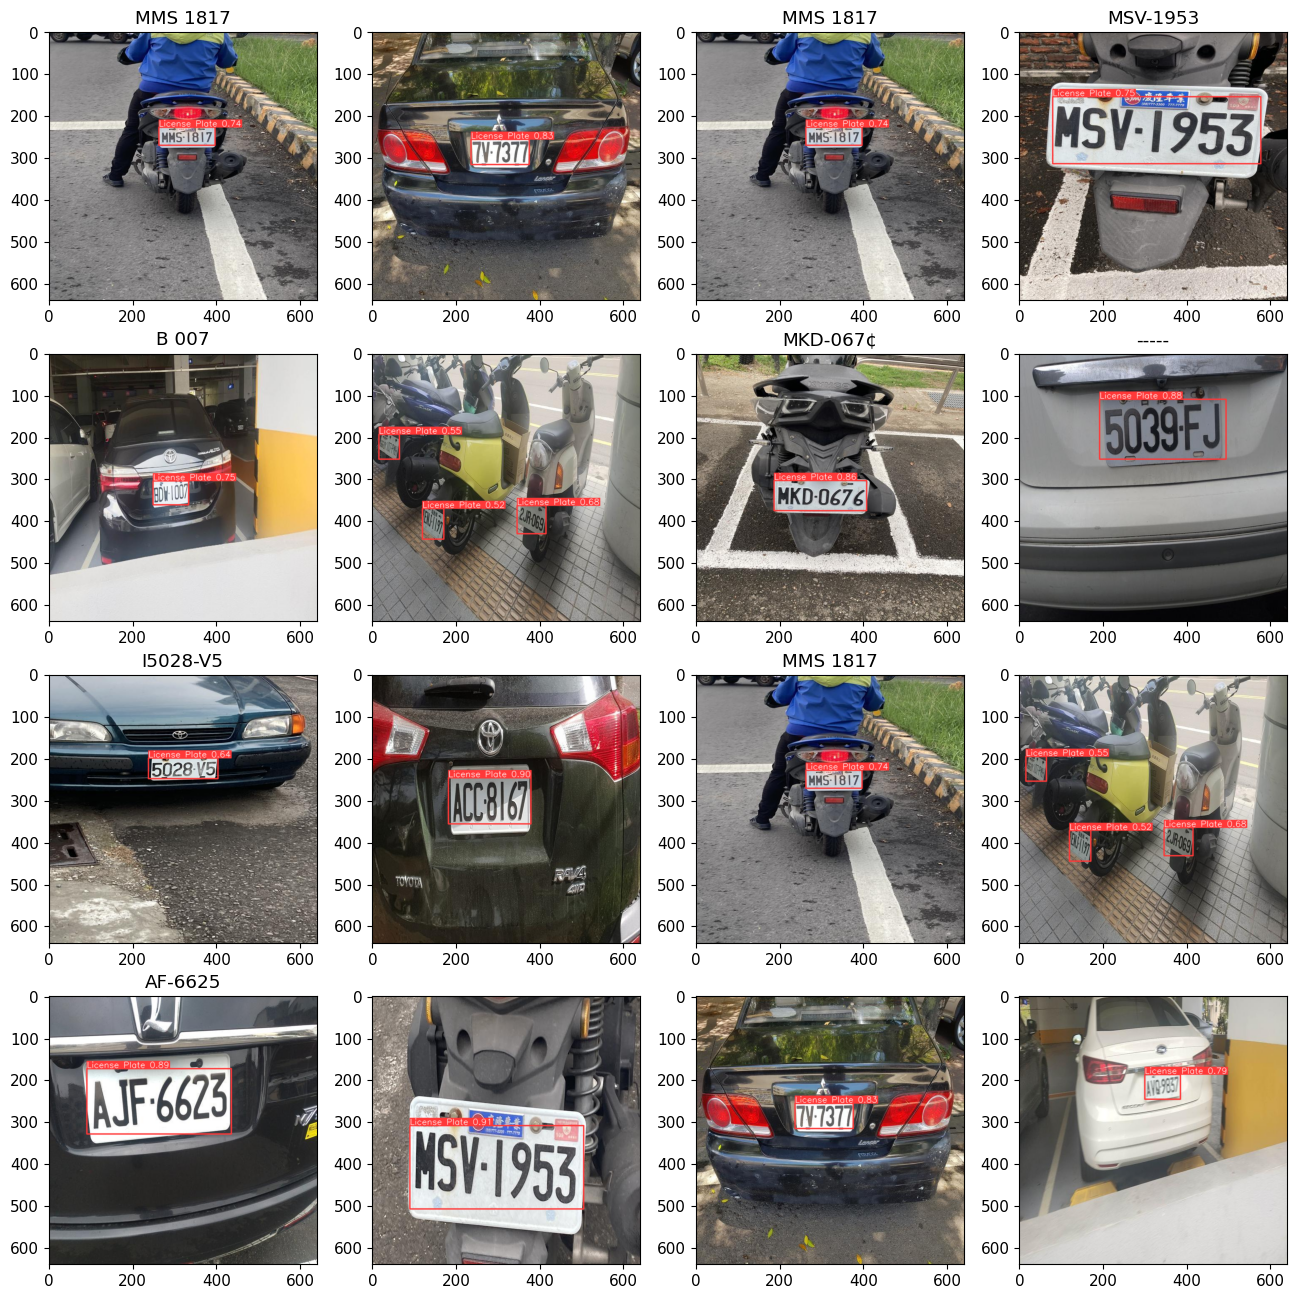

In [17]:
%matplotlib inline
# Fetching random 16 images from test set
test_files = df_test['file'].apply(lambda x: x.replace('labels','images').replace('xml','jpg'))
test_images = np.random.choice(test_files, size=(4,4))

# Visualizing predictions
fig, ax = plt.subplots(figsize=(16,16), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        # Reading the image
        image = cv2.imread(test_images[i,j])
        # Convert image to RGB colorspace
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Predicting from model
        results = model(image)
        # Getting co ordinates of license plate
        results_df = results.pandas().xyxy[0].loc[0]
        x_min = int(results_df['xmin'])
        x_max = int(results_df['xmax'])
        y_min = int(results_df['ymin'])
        y_max = int(results_df['ymax'])
        # Cropping license plate from image ""
        number_plate = image[y_min:y_max,x_min:x_max]
        # Performing OCR on image
        text = pt.image_to_string(number_plate)
        # Showing the results
        ax[i,j].set_title(str(text).strip())
        ax[i,j].imshow(np.squeeze(results.render()))
plt.show()

In [18]:
fig.savefig('result2.png')

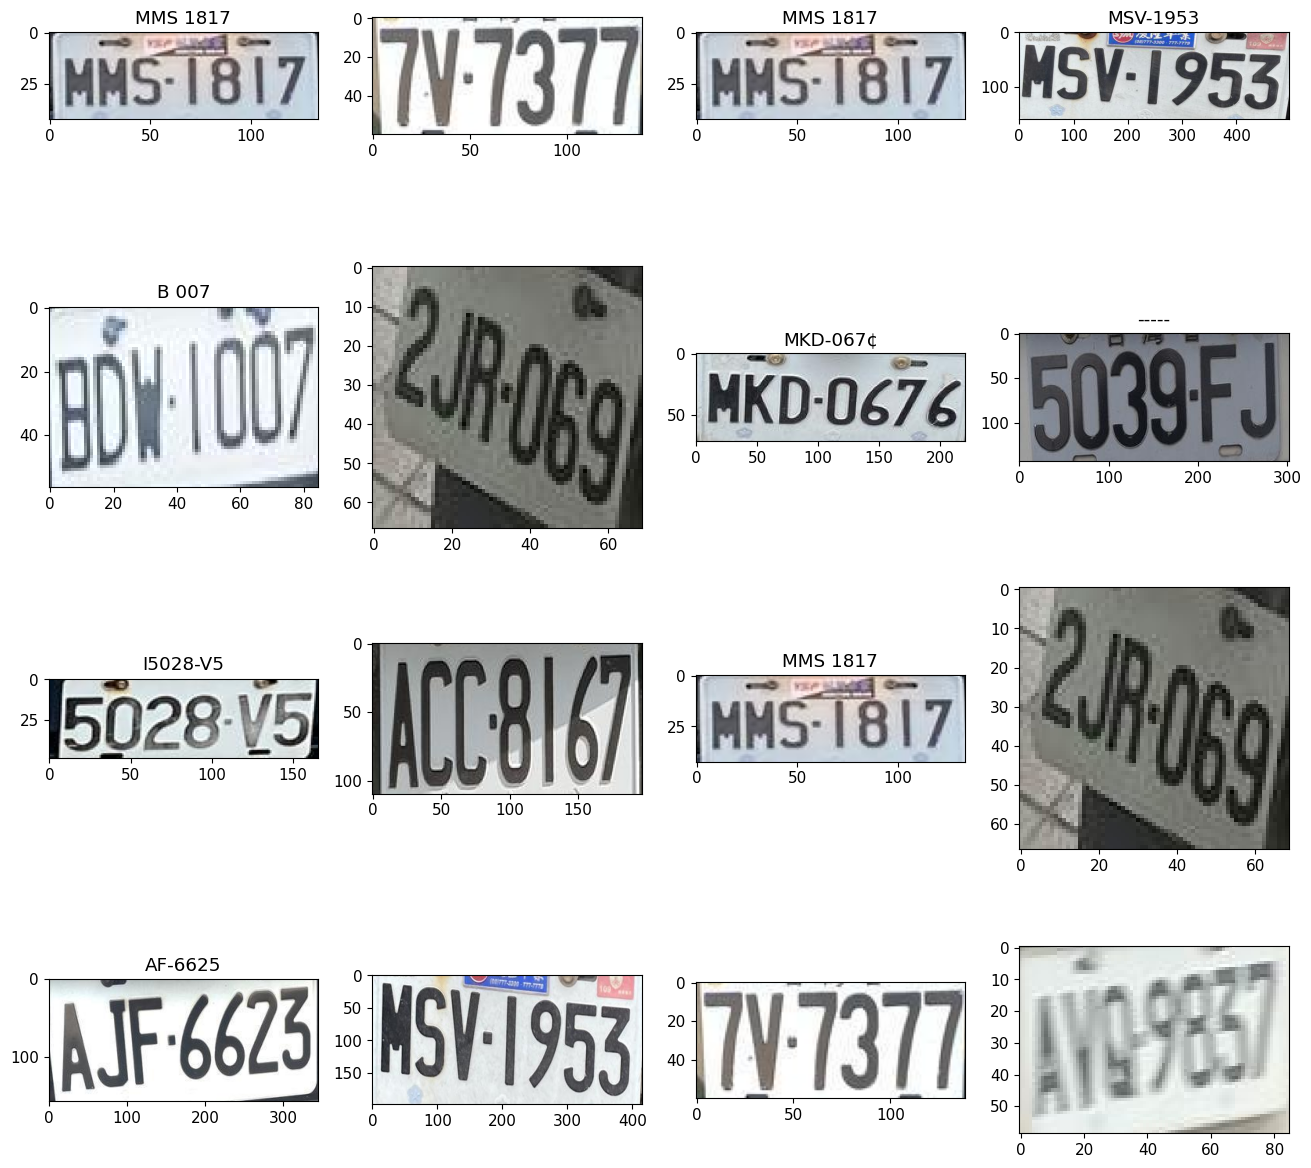

In [19]:
fig, ax = plt.subplots(figsize=(16,16), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        # Reading the image
        image = cv2.imread(test_images[i,j])
        # Convert image to RGB colorspace
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Predicting from model
        results = model(image)
        # Getting co ordinates of license plate
        results_df = results.pandas().xyxy[0].loc[0]
        x_min = int(results_df['xmin'])
        x_max = int(results_df['xmax'])
        y_min = int(results_df['ymin'])
        y_max = int(results_df['ymax'])
        # Cropping license plate from image ""
        number_plate = image[y_min:y_max,x_min:x_max]
        # Performing OCR on image
        text = pt.image_to_string(number_plate)
        # Showing the results
        ax[i,j].set_title(str(text).strip())
        ax[i,j].imshow(number_plate)
plt.show()

In [20]:
fig.savefig('result3.png')

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

from yolov5 import utils
display = utils.notebook_init()

In [ ]:
!pip install -q wandb --upgrade

import wandb
wandb.login(anonymous='must')

In [ ]:
!python train.py --img 1280\
--batch 10\
--epochs 50\
--data /kaggle/working/bgr.yaml\
--weights yolov5m6.pt

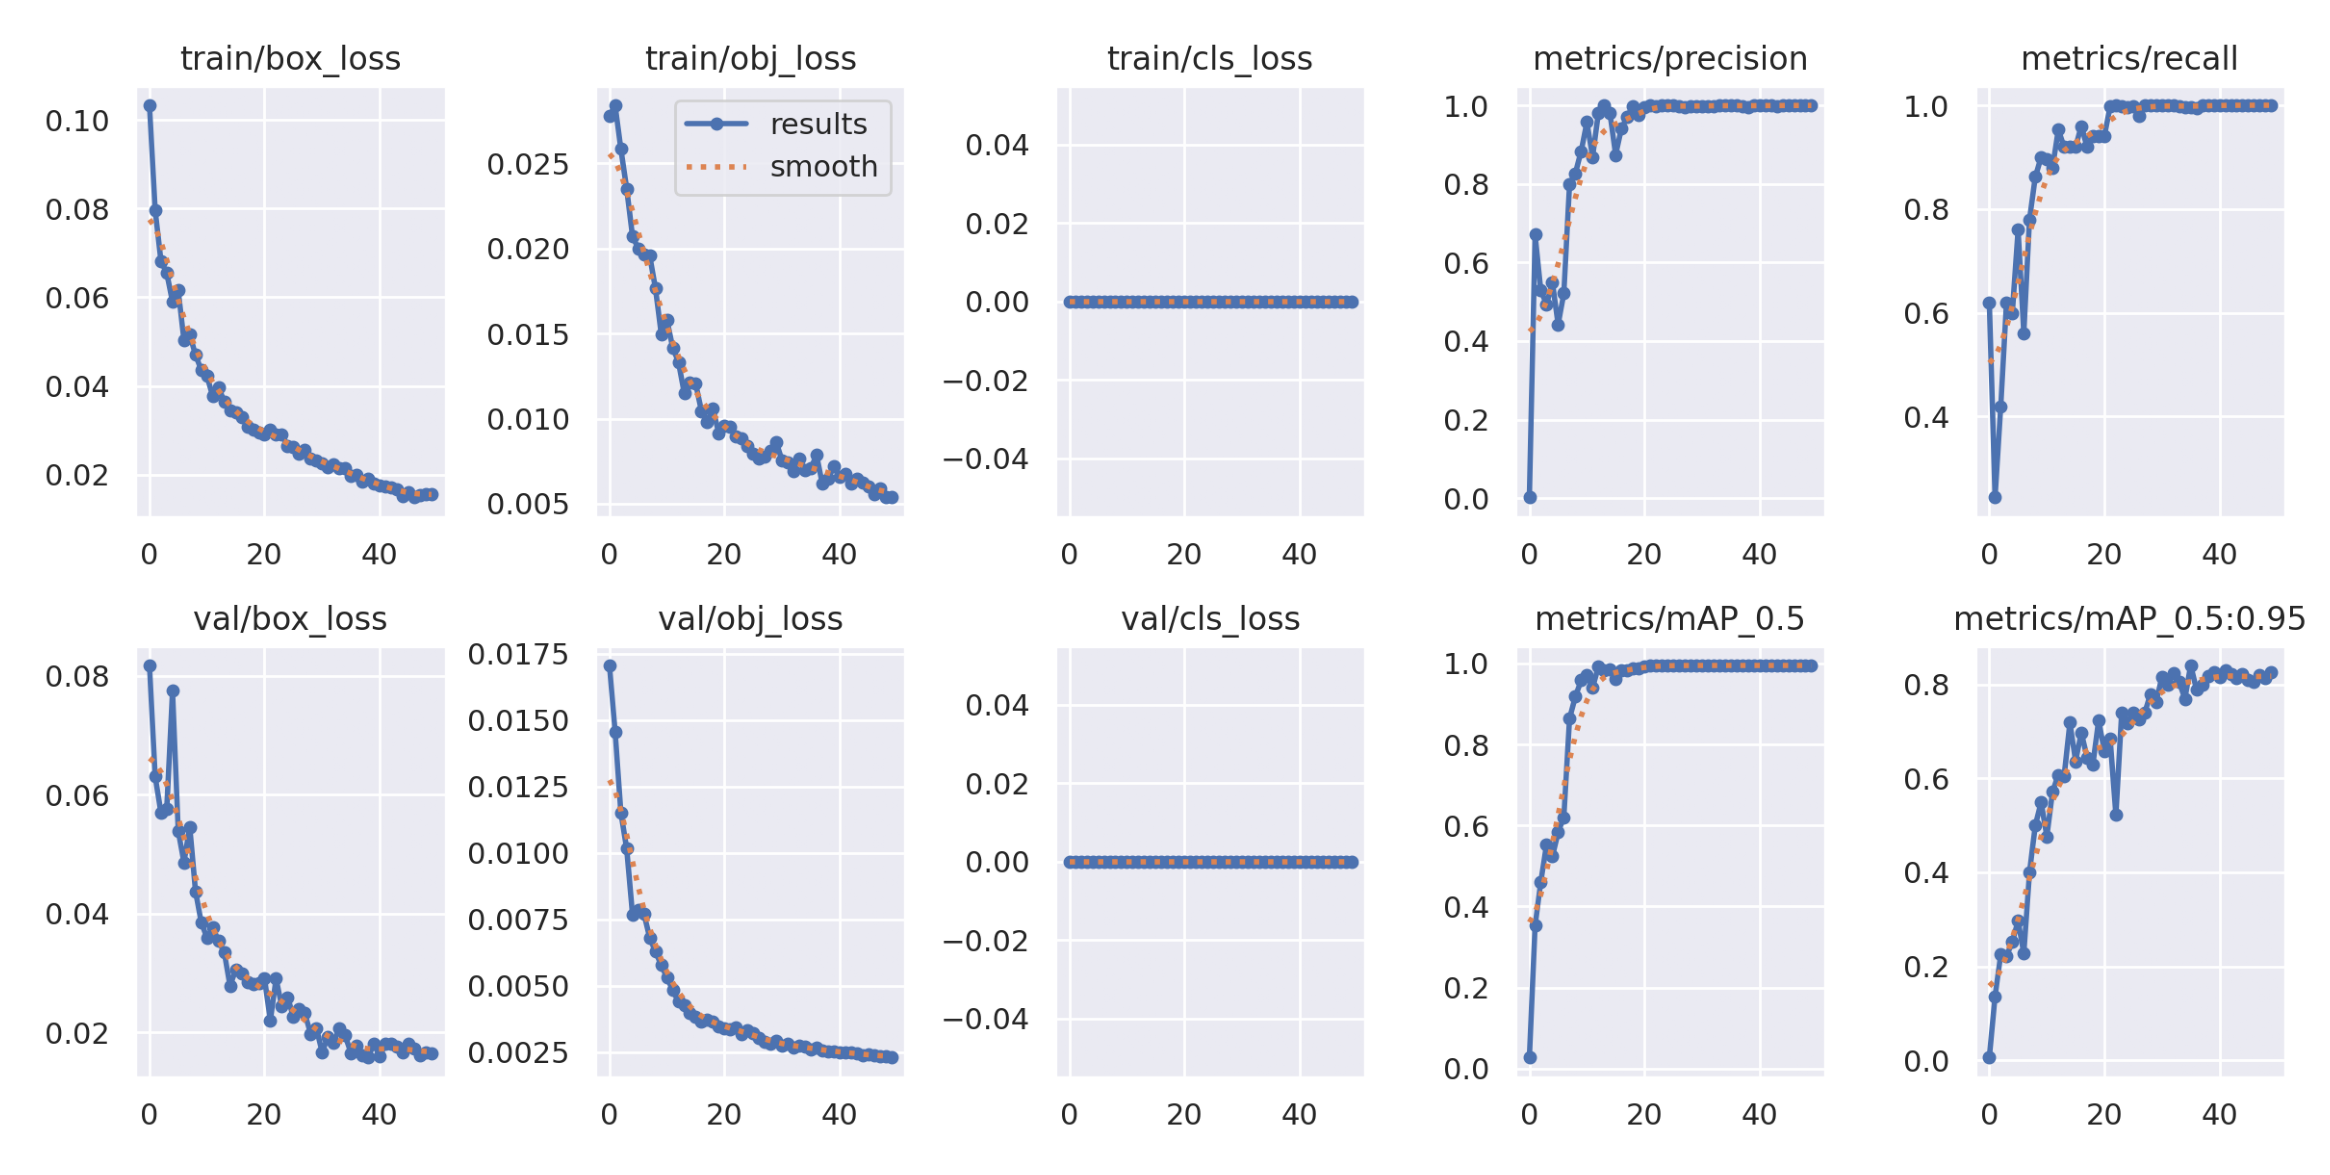

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('/content/kaggle/working/yolov5/runs/train/exp/results.png'))

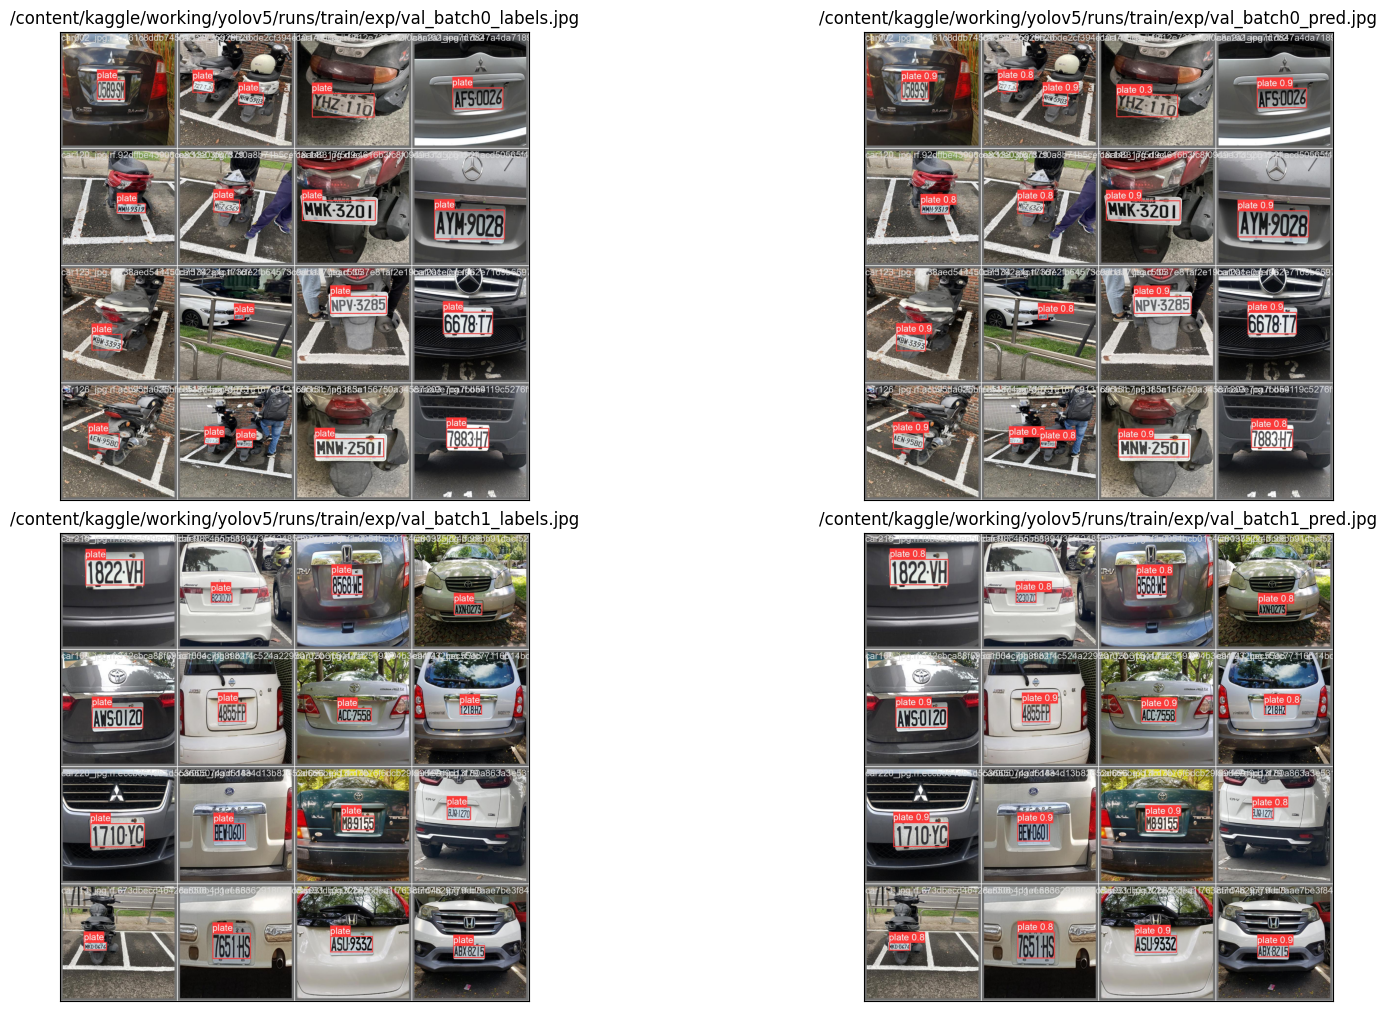

In [24]:
fig, ax = plt.subplots(2, 2, figsize = (2*8,2*5), constrained_layout = True)
for row in range(2):
    ax[row][0].imshow(plt.imread(f'/content/kaggle/working/yolov5/runs/train/exp/val_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'/content/kaggle/working/yolov5/runs/train/exp/val_batch{row}_labels.jpg', fontsize = 12)

    ax[row][1].imshow(plt.imread(f'/content/kaggle/working/yolov5/runs/train/exp/val_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'/content/kaggle/working/yolov5/runs/train/exp/val_batch{row}_pred.jpg', fontsize = 12)
plt.show()

In [25]:
import torch
from PIL import Image

CKPT_PATH = '/content/kaggle/working/yolov5/runs/train/exp/weights/best.pt'
yolov5 = torch.hub.load('/content/kaggle/working/yolov5',
                        'custom',
                        path=CKPT_PATH,
                        source='local',
                        force_reload=True)

'confidence: ' + str(yolov5.conf)

YOLOv5 🚀 v7.0-224-g6262c7f Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


'confidence: 0.25'

In [ ]:
import pandas as pd
import numpy as np

imgs = os.listdir('/content/kaggle/working/Taiwan_plate/val')

pred_df = pd.DataFrame()
for pth in imgs:
    img = Image.open('/content/kaggle/working/Taiwan_plate/val' + pth).convert('RGB')
    img = np.asarray(img)
    pred = yolov5(img, size=640, augment=False)
    for i, row in pred.pandas().xyxy[0].iterrows():
        if row['confidence'] < yolov5.conf: break
        row['path'] = pth
        pred_df = pred_df.append(row)
pred_df = pred_df.reset_index()

In [ ]:
pred_df